# Exploratory Data Analysis (EDA) — NYC Yellow Taxi 2024

## Introduction

In this section, we will perform an exploratory data analysis (EDA) on the full 12-month NYC Yellow Taxi Trip dataset, now fully loaded into MySQL (~41M records). The goal is to extract key insights and trends from the data, including:

- Total trips per month
- Average fare and tip analysis
- Payment type trends

## Why we are creating indexes

Since the dataset is large (~41 million rows), performing aggregation queries directly on the raw table can be very slow. To optimize query performance for our EDA, we will create indexes on the columns that are most frequently used in `GROUP BY`, `WHERE`, and `ORDER BY` clauses:

- `pu_location_id` → used for geospatial and pickup analysis
- `do_location_id` → used for dropoff analysis
- `tpep_pickup_datetime` → used to group trips by month and time

Creating these indexes will significantly improve the speed of our queries and make the analysis more efficient and interactive.

**Note:** The index creation step is safe to run multiple times — if an index already exists, MySQL will report it and skip re-creating it.


In [2]:
import mysql.connector
from dotenv import load_dotenv
import os

# Load env variables
load_dotenv()

# MySQL connection config
MYSQL_CONFIG = {
    'user': os.getenv('MYSQL_USER'),
    'password': os.getenv('MYSQL_PASSWORD'),
    'host': os.getenv('MYSQL_HOST'),
    'database': os.getenv('MYSQL_DATABASE'),
    'port': int(os.getenv('MYSQL_PORT'))
}

## Index Management

To optimize query performance on the `yellow_taxi_trips` table (~41M rows), we use dedicated indexes on key columns:

- `pu_location_id` → for pickup zone analysis
- `do_location_id` → for dropoff zone analysis
- `tpep_pickup_datetime` → for time-based aggregations (e.g. trips per month)

### Why use flags to control index operations?

- Creating or dropping indexes on large tables can take several minutes.
- Even attempting to create an index that already exists forces MySQL to check the table and can cause temporary performance impact.
- For this reason, index operations are controlled explicitly by `DROP_INDEXES` and `CREATE_INDEXES` flags in the notebook.

**Usage:**

- Set `DROP_INDEXES = True` to drop existing indexes if needed.
- Set `CREATE_INDEXES = True` to create the required indexes (usually run once during setup).
- Default is to skip both operations to ensure fast and safe re-runs of the notebook.

### Notes:

- Dropping and recreating indexes is safe: it does not affect the underlying table data.
- It is good practice to document and control index management in reproducible analytical pipelines.


In [ ]:
# Index Management Block
# ⚙️ Use DROP_INDEXES and CREATE_INDEXES flags to control index operations.
# ⚠️ On large tables (~41M rows), index operations can take several minutes.

DROP_INDEXES = False  # Set to True to drop existing indexes (if needed)
CREATE_INDEXES = False  # Set to True to create indexes (recommended to run only once)

# Indexes to manage
index_names = [
    "idx_pu_location_id",
    "idx_do_location_id",
    "idx_tpep_pickup_datetime"
]

index_statements = [
    ("idx_pu_location_id", "CREATE INDEX idx_pu_location_id ON yellow_taxi_trips(pu_location_id);"),
    ("idx_do_location_id", "CREATE INDEX idx_do_location_id ON yellow_taxi_trips(do_location_id);"),
    ("idx_tpep_pickup_datetime", "CREATE INDEX idx_tpep_pickup_datetime ON yellow_taxi_trips(tpep_pickup_datetime);")
]

# Connect to MySQL
cnx = mysql.connector.connect(**MYSQL_CONFIG)
cursor = cnx.cursor()

# Drop indexes if requested
if DROP_INDEXES:
    print("⚠️ Dropping indexes...")
    for index_name in index_names:
        try:
            print(f"Dropping index {index_name}...")
            cursor.execute(f"DROP INDEX {index_name} ON yellow_taxi_trips;")
            cnx.commit()
            print(f"✅ Index {index_name} dropped.")
        except mysql.connector.Error as err:
            print(f"⚠️ Could not drop index {index_name}: {err.msg}")
    print("🏁 Index drop process complete.")
else:
    print("⏭️ Skipping index drop.")

# Create indexes if requested
if CREATE_INDEXES:
    print("⚙️ Creating indexes...")
    for index_name, stmt in index_statements:
        try:
            print(f"Creating index {index_name}...")
            cursor.execute(stmt)
            cnx.commit()
            print(f"✅ Index {index_name} created.")
        except mysql.connector.Error as err:
            print(f"⚠️ Could not create index {index_name}: {err.msg}")
    print("🏁 Index creation process complete.")
else:
    print("⏭️ Skipping index creation.")

# Close connection
cursor.close()
cnx.close()


⏭️ Skipping index drop.
⏭️ Skipping index creation.


`On the initial run:`
```text
⚠️ Dropping indexes...
Dropping index idx_pu_location_id...
✅ Index idx_pu_location_id dropped.
Dropping index idx_do_location_id...
✅ Index idx_do_location_id dropped.
Dropping index idx_tpep_pickup_datetime...
⚠️ Could not drop index idx_tpep_pickup_datetime: Can't DROP 'idx_tpep_pickup_datetime'; check that column/key exists
🏁 Index drop process complete.
⚙️ Creating indexes...
Creating index idx_pu_location_id...
✅ Index idx_pu_location_id created.
Creating index idx_do_location_id...
✅ Index idx_do_location_id created.
Creating index idx_tpep_pickup_datetime...
✅ Index idx_tpep_pickup_datetime created.
🏁 Index creation process complete.
```

## Total Trips per Month

We analyze the evolution of total trips over time (monthly) to detect seasonality and trends in NYC taxi usage.


✅ Results saved to '../eda_results/total_trips_per_month.csv'


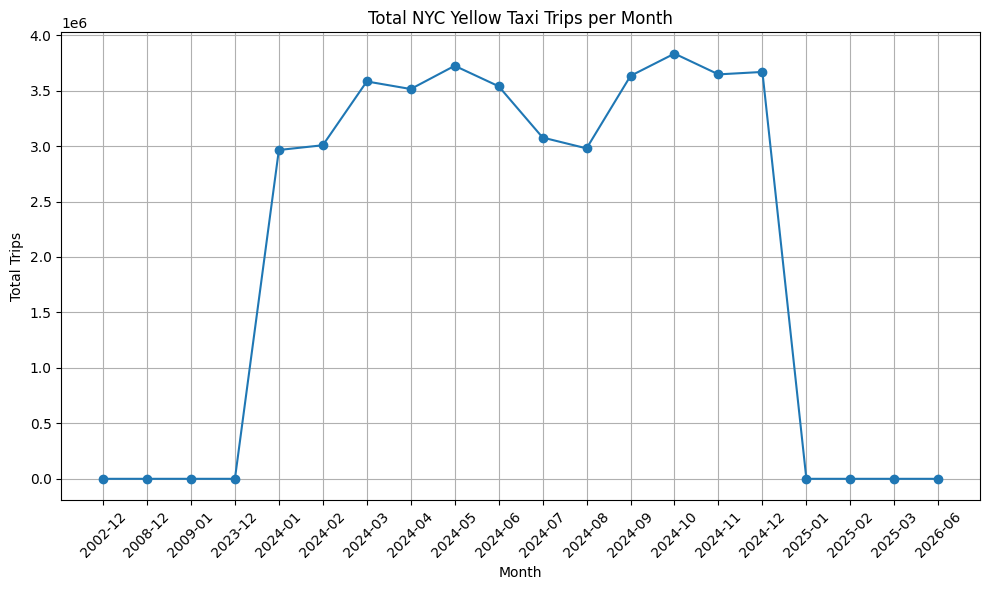

In [3]:
# Total Trips per Month

import pandas as pd
import matplotlib.pyplot as plt
import mysql.connector

# Ensure eda_results folder exists
os.makedirs('../eda_results', exist_ok=True)

# Connect to MySQL
cnx = mysql.connector.connect(**MYSQL_CONFIG)
cursor = cnx.cursor()

# SQL query: total trips per month
query = """
SELECT
    DATE_FORMAT(tpep_pickup_datetime, '%Y-%m') AS month,
    COUNT(*) AS total_trips
FROM yellow_taxi_trips
GROUP BY month
ORDER BY month;
"""

# Execute query
cursor.execute(query)
results = cursor.fetchall()

# Close connection
cursor.close()
cnx.close()

# Load results into DataFrame
df_trips_per_month = pd.DataFrame(results, columns=['month', 'total_trips'])

# Save results to CSV for future use (e.g. dashboards)
df_trips_per_month.to_csv('../eda_results/total_trips_per_month.csv', index=False)
print("✅ Results saved to '../eda_results/total_trips_per_month.csv'")

# Plot
plt.figure(figsize=(10,6))
plt.plot(df_trips_per_month['month'], df_trips_per_month['total_trips'], marker='o')
plt.title('Total NYC Yellow Taxi Trips per Month')
plt.xlabel('Month')
plt.ylabel('Total Trips')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
df_trips_per_month

,month,total_trips
0,2002-12,11
1,2008-12,10
2,2009-01,18
3,2023-12,10
4,2024-01,2964617
5,2024-02,3007533
6,2024-03,3582611
7,2024-04,3514295
8,2024-05,3723843
9,2024-06,3539170
